# Learning a Repertoire of Robot Arm Configurations with IsoLineEmitter

In this tutorial, we demonstrate how to use MAP-Elites to solve an inverse kinematics problem.

## Overview

Inverse kinematics is an important robotics problem in which, given a final robot configuration, one must figure out the actions to take to accomplish that position. (TODO: update this)

In this example, we will deal with a planar (2D) 12-DoF arm that needs to move its end effector to a certain position. Using MAP-Elites, we will find joint configurations that move the arm to a wide variety of positions.

## Setup

In [1]:
%pip install ribs[all]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

from ribs.archives import CVTArchive
from ribs.emitters import IsoLineEmitter
from ribs.optimizers import Optimizer
from ribs.visualize import cvt_archive_heatmap

## Objective and Behavior Characteristics

In [3]:
def simulate(solutions, joint_lengths):
    """Returns the objective values and BCs for a batch of solutions."""
    n_dim = joint_lengths.shape[0]
    sums = np.mean(solutions, axis=1, keepdims=True)
    objs = -np.sum((solutions - sums) ** 2, axis=1) / n_dim

    cumsum = np.cumsum(solutions, axis=1)
    x_pos = joint_lengths[None] * np.cos(cumsum)
    y_pos = joint_lengths[None] * np.sin(cumsum)
    bcs = np.concatenate(
        (
            np.sum(x_pos, axis=1, keepdims=True),
            np.sum(y_pos, axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objs, bcs

## Running MAP-Elites

TODO: plot archive size and fitness across iters, add in other algos?

In [4]:
dof = 12
joint_lengths = np.ones(dof) / dof
archive = CVTArchive([(-1, 1), (-1, 1)], 10000, use_kd_tree=True)
emitters = [
    IsoLineEmitter(np.zeros(dof),
                   archive,
                   iso_sigma=0.01,
                   line_sigma=0.2,
                   bounds=[(-np.pi, np.pi)] * dof,
                   batch_size=64)
]
opt = Optimizer(archive, emitters)

In [5]:
start_time = time.time()
means = []
itrs = []
for i in range(1500):
    sols = opt.ask()
    objs, bcs = simulate(sols, joint_lengths)

    opt.tell(objs, bcs)

    if (i + 1) % 100 == 0:
        means.append(archive.as_pandas()["objective"].mean())
        itrs.append(i + 1)
        print(f"Finished {i + 1} itrs after {time.time() - start_time} s")

Finished 100 itrs after 0.9666078090667725 s
Finished 200 itrs after 1.5431365966796875 s
Finished 300 itrs after 2.1018178462982178 s
Finished 400 itrs after 2.6568236351013184 s
Finished 500 itrs after 3.260066032409668 s
Finished 600 itrs after 3.8411316871643066 s
Finished 700 itrs after 4.5100789070129395 s
Finished 800 itrs after 5.203248739242554 s
Finished 900 itrs after 5.872151613235474 s
Finished 1000 itrs after 6.463135480880737 s
Finished 1100 itrs after 7.036122560501099 s
Finished 1200 itrs after 7.649327993392944 s
Finished 1300 itrs after 8.201685905456543 s
Finished 1400 itrs after 8.793442249298096 s
Finished 1500 itrs after 9.374592304229736 s


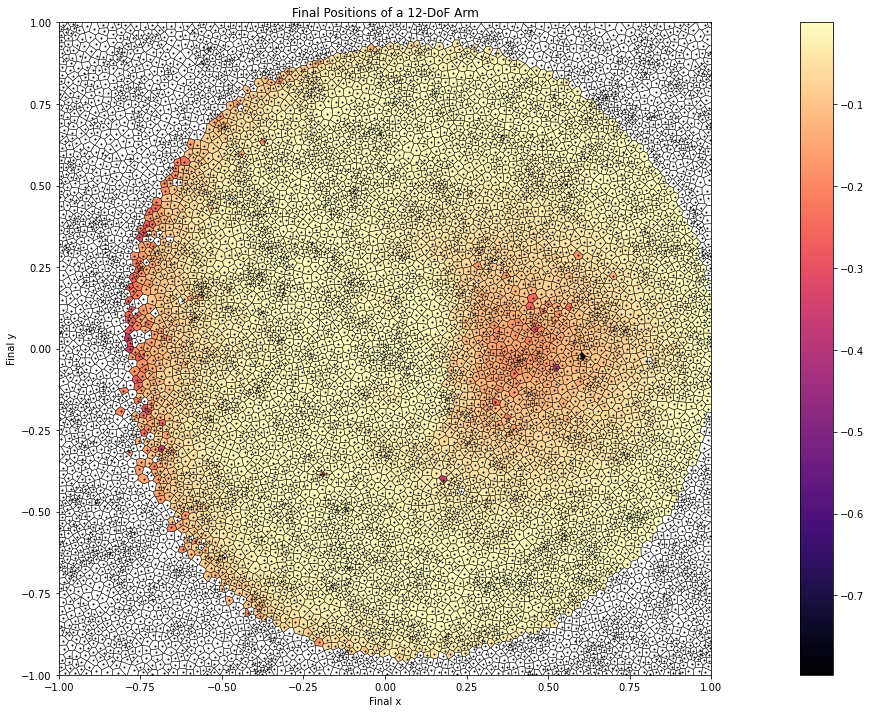

In [6]:
fig, ax = cvt_archive_heatmap(archive, figsize=(16, 12))
ax.set_xlabel("Final x")
ax.set_ylabel("Final y")
ax.set_title("Final Positions of a 12-DoF Arm");

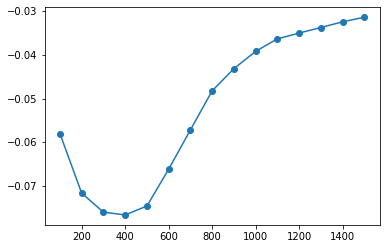

In [7]:
plt.plot(itrs, means, "-o")

## Visualization

Here we visualize several randomly selected elites in the archive.

In [8]:
def visualize(angles, joint_lengths, ax):
    """Plots an arm with the given angles and joint lengths on ax.
    
    angles and joint_lengths are assumed to be the same length.
    """
    ax.set_aspect("equal")
    lim = 1.05 * np.sum(joint_lengths)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    cumsum = np.cumsum(angles)
    pos = np.array([0, 0])
    for i in range(len(angles)):
        next_pos = pos + joint_lengths[i] * np.array(
            [np.cos(cumsum[i]), np.sin(cumsum[i])])
        ax.plot([pos[0], next_pos[0]], [pos[1], next_pos[1]], "-ko", ms=3)
        pos = next_pos
    ax.plot(0, 0, "ro", ms=6)
    final_label = f"Final: ({pos[0]:.2f}, {pos[1]:.2f})"
    ax.plot(pos[0], pos[1], "go", ms=6, label=final_label)
    ax.legend()

-0.03419457152483087 [0.10534346 0.32378058]
[-0.00265379  0.06144352  0.11129536  0.29996589  0.33310893  0.27383942
  0.41357424  0.40512105  0.61736567  0.61607176  0.33382599  0.34999258]
-0.15102231694514767 [0.41182681 0.01298864]
[-0.26483928 -0.4447059  -0.25345868 -0.06581138  0.36904473  0.42375104
  0.44936963  0.2784306   0.68172939  0.72101284  0.30148849  0.71500785]
-0.006209684069330318 [ 0.21799196 -0.62666807]
[-0.13984533 -0.08653272 -0.13988722 -0.19119873 -0.27672701 -0.21656797
 -0.24627375 -0.238411   -0.31540224 -0.3470019  -0.29257765 -0.32395591]
-0.07100671340147731 [ 0.21181866 -0.15101566]
[0.82266913 1.09879537 0.84240054 0.65545496 0.70315482 0.45888571
 0.35313329 0.57563063 0.35753965 0.30854434 0.19998562 0.24839796]


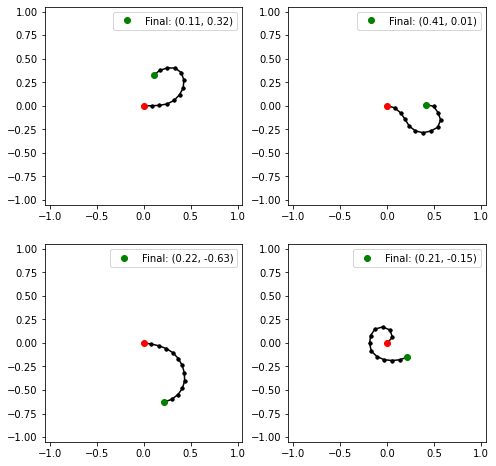

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(len(ax)):
    solution, objective, behavior = archive.get_random_elite()
    print(objective, behavior)
    print(solution)
    visualize(solution, joint_lengths, ax[i])

## Analyzing Results

Here, we will print out all the solutions we found.

## Conclusion

In this tutorial, we...